In [28]:
!pip install transformers
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Ariste Mathiot, Nicolas Marchand, Neil Mahcer DIA5

# Next word prediction

Dans ce projet, nous avons développé un modèle de prédiction de texte capable de suggérer le prochain mot d'une phrase. Nous avons comparé différentes approches, allant des LSTM classiques aux Transformers modernes, jusqu’à des modèles pré-entraînés comme DistilGPT2, afin d’évaluer leur efficacité sur une tâche de complétion de texte.

Le dataset « Sherlock Holmes Book Text Data » contient le texte complet des histoires de détective écrites par Sir Arthur Conan Doyle mettant en scène Sherlock Holmes. Ce jeu de données est conçu pour des tâches de prédiction de texte et de modélisation du mot suivant.

Il comprend le texte original des récits de Sherlock Holmes, permettant aux utilisateurs d’analyser les structures linguistiques et de développer des algorithmes capables de prédire le mot suivant d’une phrase en fonction du contexte fourni par le texte.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Read the text file
with open('sherlock-holm.es_stories_plain-text_advs.txt', 'r', encoding='utf-8') as file:
    text = file.read()

Creation du dataset:
- Transformer le text en sequence 
- Utliser la technique du n_gram pour qu'il puisse mieux comprendre le sens des phrases

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1
total_words

8200

In [6]:
input_sequences = []
a=1
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [7]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [8]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

In [66]:
from sklearn.model_selection import train_test_split
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_words))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
len(X_test)

19263

In [68]:
total_words, max_sequence_len, X.shape, y.shape, input_sequences.shape

(8200, 18, (96314, 17), (96314, 8200), (96314, 18))

# RNN

# Utilisation d'un RNN tout simple avec du early stopping sur le val_loss

Les RNN sont des réseaux conçus pour traiter des données séquentielles (texte, séries temporelles, audio...) où chaque sortie dépend des entrées précédentes. Ils "mémorisent" une information d’état via des poids récurrents, qui évoluent au fil des étapes de la séquence.

Problème de vanishing gradients sur les longues séquences.

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN as RNN
model_RNN = Sequential()
model_RNN.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_RNN.add(RNN(150))
model_RNN.add(Dense(total_words, activation='softmax'))

# Construire le modèle
model_RNN.build(input_shape=(None, max_sequence_len-1))

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte pendant l'entraînement
    patience=5,      # Arrêter si la perte ne s'améliore pas après 3 époques
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)
# Afficher le résumé
print(model_RNN.summary())

C:\Users\arist\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 17, 100)        │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 150)            │        37,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8200)           │     1,238,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,095,850 (8.00 MB)

 Trainable params: 2,095,850 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [52]:
model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_RNN=model_RNN.fit(X_train, y_train, epochs=100, batch_size=32 ,verbose=1,validation_data=(X_test,y_test), callbacks=[early_stopping])
model_RNN.save("modelRNN.h5")

Epoch 1/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.0653 - loss: 6.5417 - val_accuracy: 0.1136 - val_loss: 5.8434
Epoch 2/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.1216 - loss: 5.4396 - val_accuracy: 0.1320 - val_loss: 5.7036
Epoch 3/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.1561 - loss: 4.9220 - val_accuracy: 0.1354 - val_loss: 5.7363
Epoch 4/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.1797 - loss: 4.4958 - val_accuracy: 0.1397 - val_loss: 5.8124
Epoch 5/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.2130 - loss: 4.0954 - val_accuracy: 0.1341 - val_loss: 5.9343
Epoch 6/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.2506 - loss: 3.7362 - val_accuracy: 0.1341 - val_loss: 6.0516
Epoch 7/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.2994 - loss: 3.4012 - val_accuracy: 0.1311 - val_loss: 6.1889


Il s'arrete à 7 epochs ce qui me parait peu.

# Utilisation du dropout pour qu'il puisse etre plus general et ne pas overfitt

Cela rend l’apprentissage plus lent (et donc une accuracy plus basse au début), mais le modèle généralise mieux sur les données jamais vues.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
# Définition du modèle avec des couches supplémentaires et du Dropout
model_RNN_drop = Sequential()
model_RNN_drop.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_RNN_drop.add(RNN(150, return_sequences=True))  # LSTM avec retour des séquences
model_RNN_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_RNN_drop.add(RNN(100))  # Deuxième couche LSTM
model_RNN_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_RNN_drop.add(Dense(128, activation='relu'))  # Couche Dense intermédiaire
model_RNN_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_RNN_drop.add(Dense(total_words, activation='softmax'))  # Couche de sortie

# Construire le modèle
model_RNN_drop.build(input_shape=(None, max_sequence_len-1))

# Afficher le résumé
print(model_RNN_drop.summary())

# Compilation du modèle
model_RNN_drop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Configuration de l'Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte pendant l'entraînement
    patience=5,      # Arrêter si la perte ne s'améliore pas après 3 époques
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

# Entraînement du modèle avec Early Stopping
history_RNN_drop=model_RNN_drop.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_test,y_test) ,verbose=1, callbacks=[early_stopping])

model_RNN_drop.save("modelRNN_dropout.h5")

C:\Users\arist\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 17, 100)        │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 17, 150)        │        37,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 17, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8200)           │     1,057,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953,478 (7.45 MB)

 Trainable params: 1,953,478 (7.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.0533 - loss: 6.7163 - val_accuracy: 0.0573 - val_loss: 6.3465
Epoch 2/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.0612 - loss: 6.3077 - val_accuracy: 0.0695 - val_loss: 6.3299
Epoch 3/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.0661 - loss: 6.1558 - val_accuracy: 0.0743 - val_loss: 6.2978
Epoch 4/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.0687 - loss: 6.0590 - val_accuracy: 0.0745 - val_loss: 6.3251
Epoch 5/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.0722 - loss: 5.9552 - val_accuracy: 0.0811 - val_loss: 6.3311
Epoch 6/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.0768 - loss: 5.8850 - val_accuracy: 0.0843 - val_loss: 6.3747
Epoch 7/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.0807 - loss: 5.8186 - val_accuracy: 0.0860 - val_loss: 6.3454
Epoch 8/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accur

Donc, d'après les metrics d'evaluation, le modèle sans le dropout est meilleur. Mais, je pense que s'il on laissait le modele avec dropout plus s'entrainer on obtiendrait des meilleurs résultats.

# LSTM Simple

Les LSTM sont une version améliorée des RNN, conçue pour résoudre le problème de mémoire courte. 
Grâce à des portes (input, forget, output), ils gèrent mieux quelles informations garder ou oublier dans la séquence.

Regle le problème du vanishing gradient.

J'ai essayé de changer le batch size.

Conclusion:

Le batch size à 32 est mieux qu'à 128


Pour le early stopping il s'arrete à 8 mais je pense qu'il peut apprendre un peu plus donc j'ai augmenté la patience dans le early stopping.



In [42]:
from tensorflow.keras.callbacks import EarlyStopping
model_earlystopping = Sequential()
model_earlystopping.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_earlystopping.add(LSTM(150))
model_earlystopping.add(Dense(total_words, activation='softmax'))

# Construire le modèle
model_earlystopping.build(input_shape=(None, max_sequence_len-1))

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte pendant l'entraînement
    patience=5,      # Arrêter si la perte ne s'améliore pas après 3 époques
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)
# Afficher le résumé
print(model_earlystopping.summary())

C:\Users\arist\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 17, 100)        │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8200)           │     1,238,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,208,800 (8.43 MB)

 Trainable params: 2,208,800 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_earlystopping.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_earlystopping=model_earlystopping.fit(X_train, y_train, epochs=100, batch_size=32 ,verbose=1,validation_data=(X_test,y_test), callbacks=[early_stopping])
model.save("modelLSMTsimple_earlystopping.h5")

J'ai decidé de faire les 100 epochs pour visualiser si c'est juste le début ou le modele s'améliore à un moment.

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))

# Construire le modèle
model.build(input_shape=(None, max_sequence_len-1))

# Afficher le résumé
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 17, 100)        │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8200)           │     1,238,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,208,800 (8.43 MB)

 Trainable params: 2,208,800 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

None


In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=100, batch_size=32 ,verbose=1,validation_data=(X_test,y_test))
model.save("modelLSMTsimple.h5")

Epoch 1/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.1579 - loss: 5.1289 - val_accuracy: 0.1394 - val_loss: 5.6777
Epoch 2/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.1726 - loss: 4.8121 - val_accuracy: 0.1417 - val_loss: 5.7626
Epoch 3/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.1961 - loss: 4.4022 - val_accuracy: 0.1381 - val_loss: 5.8601
Epoch 4/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.2158 - loss: 4.0684 - val_accuracy: 0.1394 - val_loss: 5.9793
Epoch 5/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.2513 - loss: 3.7469 - val_accuracy: 0.1391 - val_loss: 6.1046
Epoch 6/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.2920 - loss: 3.4568 - val_accuracy: 0.1334 - val_loss: 6.2529
Epoch 7/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.3344 - loss: 3.1783 - val_accuracy: 0.1279 - val_loss: 6.3767
Epoch 8/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 

Ici grâce au graphique on voit bien que le meilleur epoch est à 5 ou 6 sinon ça devient de l'overfitting

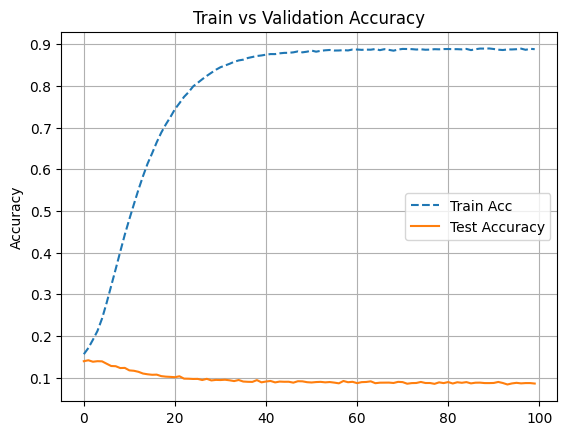

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], linestyle='--', label=f'Train Acc ')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Train vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Rajout du dropout LSTM

In [71]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
# Définition du modèle avec des couches supplémentaires et du Dropout
model_drop = Sequential()
model_drop.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_drop.add(LSTM(150, return_sequences=True))  # LSTM avec retour des séquences
model_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_drop.add(LSTM(100))  # Deuxième couche LSTM
model_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_drop.add(Dense(128, activation='relu'))  # Couche Dense intermédiaire
model_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_drop.add(Dense(total_words, activation='softmax'))  # Couche de sortie

# Construire le modèle
model_drop.build(input_shape=(None, max_sequence_len-1))

# Afficher le résumé
print(model_drop.summary())

# Compilation du modèle
model_drop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Configuration de l'Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte pendant l'entraînement
    patience=5,      # Arrêter si la perte ne s'améliore pas après 3 époques
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

# Entraînement du modèle avec Early Stopping
history_drop=model_drop.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_test,y_test) ,verbose=1, callbacks=[early_stopping])

model_drop.save("modelLSMT_dropout.h5")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 17, 100)        │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 17, 150)        │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 17, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8200)           │     1,057,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,141,728 (8.17 MB)

 Trainable params: 2,141,728 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.0522 - loss: 6.6378 - val_accuracy: 0.0637 - val_loss: 6.2212
Epoch 2/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.0688 - loss: 6.0632 - val_accuracy: 0.0875 - val_loss: 6.0528
Epoch 3/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.0909 - loss: 5.8009 - val_accuracy: 0.1005 - val_loss: 5.9987
Epoch 4/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.1087 - loss: 5.5748 - val_accuracy: 0.1107 - val_loss: 5.9750
Epoch 5/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.1173 - loss: 5.4374 - val_accuracy: 0.1189 - val_loss: 5.9821
Epoch 6/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.1246 - loss: 5.3350 - val_accuracy: 0.1216 - val_loss: 6.0233
Epoch 7/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.1289 - loss: 5.2132 - val_accuracy: 0.1252 - val_loss: 6.0312
Epoch 8/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accur

Ici, le meilleur modèle est celui avec le dropout.

# Reflexion sur la metrics d'évaluation

J'ai pensé que l'accuracy était une mauvaise metrics pour evaluer les modeles NLP. Du au nombre de choix acceptable. Puis j'ai trouvé perplixity et top k accuracy.

La perplexité est une mesure couramment utilisée pour évaluer les modèles de langage. Elle mesure à quel point le modèle est surpris par une séquence de mots. Une perplexité plus faible indique un meilleur modèle.

Top k accuracy mesure le pourcentage de fois où le vrai mot suivant est parmi les K mots les plus probables prédits par le modèle.

Ici, j'ai essayé de mettre en place la metrics perplixity.

In [75]:
# Définir une métrique personnalisée pour la perplexité
class PerplexityMetric(Callback):
    def __init__(self, patience=5):
        super(PerplexityMetric, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.best_perplexity = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('val_loss')
        perplexity = 2 ** loss
        print(f'\nEpoch {epoch + 1}, Validation Perplexity: {perplexity:.4f}')

        if perplexity < self.best_perplexity:
            self.best_perplexity = perplexity
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
                print(f'\nRestoring model weights from the end of the best epoch.')

In [76]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import numpy as np

# Définition du modèle avec des couches supplémentaires et du Dropout
model_drop = Sequential()
model_drop.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model_drop.add(LSTM(150, return_sequences=True))  # LSTM avec retour des séquences
model_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_drop.add(LSTM(100))  # Deuxième couche LSTM
model_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_drop.add(Dense(128, activation='relu'))  # Couche Dense intermédiaire
model_drop.add(Dropout(0.2))  # Dropout pour régularisation
model_drop.add(Dense(total_words, activation='softmax'))  # Couche de sortie

# Construire le modèle
model_drop.build(input_shape=(None, max_sequence_len-1))

# Afficher le résumé
print(model_drop.summary())


# Compilation du modèle
model_drop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Créer une instance de la métrique personnalisée pour la perplexité
perplexity_metric = PerplexityMetric(patience=5)

# Entraînement du modèle avec Early Stopping et la métrique de perplexité
history_drop = model_drop.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[perplexity_metric]
)

# Sauvegarder le modèle
model_drop.save("modelLSMT_dropout.h5")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 17, 100)        │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 17, 150)        │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 17, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8200)           │     1,057,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,141,728 (8.17 MB)

 Trainable params: 2,141,728 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
2406/2408 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0516 - loss: 6.6406
Epoch 1, Validation Perplexity: 75.2944
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.0516 - loss: 6.6403 - val_accuracy: 0.0673 - val_loss: 6.2345
Epoch 2/100
2407/2408 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0694 - loss: 6.0724
Epoch 2, Validation Perplexity: 66.5688
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - accuracy: 0.0695 - loss: 6.0724 - val_accuracy: 0.0866 - val_loss: 6.0568
Epoch 3/100
2406/2408 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0910 - loss: 5.7839
Epoch 3, Validation Perplexity: 62.8563
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.0910 - loss: 5.7839 - val_accuracy: 0.0989 - val_loss: 5.9740
Epoch 4/100
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1038 - loss: 5.5948
Epoch 4, Validation Perplexity: 63.5616
2408/2408 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.1038 - loss: 5.5948 - val_accuracy: 0.1073 - val_loss

Bon on voit que l'entrainement du modèle ne dépasse pas les 8 ou 9 epochs même avec d'autres metrics que le loss.

# Transformer

Les Transformers reposent entièrement sur des mécanismes d’attention (Self-Attention) au lieu d’une mémoire séquentielle. Cela permet d’apprendre les relations entre tous les mots d’une séquence en parallèle.

In [43]:
from transformers import AutoTokenizer
import numpy as np

# Charger le tokenizer du modèle préentraîné
tokenizer_hf = AutoTokenizer.from_pretrained("distilgpt2")

# Lire le fichier
with open('sherlock-holm.es_stories_plain-text_advs.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Découper le texte en lignes puis mots
lines = [line.strip() for line in text.split('\n') if line.strip()]

X = []
y = []

for sentence in lines:
    words = sentence.strip().split()
    if len(words) > 1:
        X.append(' '.join(words[:-1]))  # tous sauf le dernier mot
        y.append(words[-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Charger le tokenizer et le modèle
tokenizer_gpt2 = AutoTokenizer.from_pretrained("distilgpt2")
model_gpt2 = AutoModelForCausalLM.from_pretrained("distilgpt2")
model_gpt2.eval()  # mode évaluation

# Utiliser CUDA si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt2.to(device)

correct = 0
total = 0

for i in range(len(X_test)):
    input_text = X_test[i]
    true_token = y_test[i]

    # Tokenize l'entrée
    input_ids = tokenizer_gpt2.encode(input_text, return_tensors='pt').to(device)

    # Générer 1 token après la phrase
    with torch.no_grad():
        output = model_gpt2.generate(input_ids, max_length=input_ids.shape[1] + 1, do_sample=False)

    # Récupérer le dernier token généré
    generated_token_id = output[0][-1].item()
    generated_token = tokenizer_gpt2.decode([generated_token_id])

    # Nettoyage simple du token attendu
    expected = tokenizer_gpt2.convert_tokens_to_string([true_token]).strip()
    predicted = generated_token.strip()

    if expected == predicted:
        correct += 1
    total += 1

accuracy = correct / total if total > 0 else 0

print(f"Accuracy sur {total} exemples : {accuracy * 100:.2f}%")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Accuracy sur 1852 exemples : 16.47%


Donc, on a ici la meilleur accuracy mais il est testé sur moins de donnée.

# Sauvegarde des modèles

In [ ]:
from tensorflow.keras.models import load_model

model_lstm = load_model("modelLSMTsimple.h5") # celui la il est pas mal (100 epochs)
# Cela se sont arretés avant 10 epochs
model_earlystopping = load_model("modelLSMTsimple_earlystopping.h5") 
model_RNN = load_model("modelRNN.h5")
model_RNN_drop = load_model("modelRNN_dropout.h5")
model_lsmt_drop = load_model("modelLSMT_dropout.h5") 

In [13]:
import numpy as np

seed_text = "My job is being"
next_words = 1

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predictions = model.predict(token_list, verbose=0)[0]
    
    # Obtenir les indices des 3 mots les plus probables
    top_3_indices = np.argsort(predictions)[-3:][::-1]
    
    # Trouver les mots correspondants
    top_3_words = [word for word, index in tokenizer.word_index.items() if index in top_3_indices]
    
    # Ajouter le mot le plus probable au texte
    seed_text += " " + top_3_words[0]  # Utiliser le mot le plus probable
    
    print(f"Top 3 mots possibles: {top_3_words}")

print(f"Texte généré : {seed_text}")

Top 3 mots possibles: ['here', 'such', 'many']
Texte généré : My job is being here


# Interface pour tester les modèles

Les modeles ont été entrainer sur un texte anglais donc ils peuvent que predire si les mots avant sont anglais.

In [17]:
import numpy as np
import gradio as gr
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, TFAutoModelForCausalLM
import tensorflow as tf

# Fonction de prédiction
def predict_next_words(model, tokenizer, max_sequence_len, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    predictions = model.predict(token_list, verbose=0)[0]
    
    top_3_indices = np.argsort(predictions)[-3:][::-1]
    top_3_words = [word for word, index in tokenizer.word_index.items() if index in top_3_indices]

    return f"Top 3 mots possibles : {top_3_words}"

def predict_next_words_gpt2(model, tokenizer, seed_text):
    input_ids = tokenizer.encode(seed_text, return_tensors='tf')
    outputs = model(input_ids)
    
    predictions = outputs.logits[0, -1, :].numpy()
    top_3_indices = np.argsort(predictions)[-3:][::-1]

    # Décodage clair en supprimant les espaces inutiles
    top_3_words = []
    for idx in top_3_indices:
        word = tokenizer.decode([idx]).strip()
        # Filtrer les tokens bizarres
        if word not in ["", " ", "\n"]:
            top_3_words.append(word)

    return f"Top 3 mots possibles : {top_3_words}"


# Interface Gradio
def interface(seed_text, model_name):
    # Ici tu charges le bon modèle selon la sélection
    if model_name == "LSTM":
        model = model_lstm
        tokenizer_used = tokenizer
        max_seq_len = max_sequence_len
        return predict_next_words(model, tokenizer_used, max_seq_len, seed_text)
    elif model_name == "RNN":
        model = model_RNN
        tokenizer_used = tokenizer
        max_seq_len = max_sequence_len
        return predict_next_words(model, tokenizer_used, max_seq_len, seed_text)
    elif model_name == "DistilGPT2":
        return predict_next_words_gpt2(gpt2_model, gpt2_tokenizer, seed_text)
    else:
        return "Modèle inconnu."

# Chargement de DistilGPT2 pré-entraîné
gpt2_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
gpt2_model = TFAutoModelForCausalLM.from_pretrained("distilgpt2")



# Lancer l'interface
models = ["LSTM", "RNN", "DistilGPT2"]
interface_gradio = gr.Interface(
    fn=interface,
    inputs=[gr.Textbox(label="Votre phrase"), gr.Dropdown(models, label="Choisissez un modèle")],
    outputs=gr.Textbox(label="Prédictions des mots")
)

interface_gradio.launch()


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Conclusion:

D'après les metrics, le transformer gpt2 et le modele lstm avec dropdown et early stopping sont les meilleurs. Mais, on regarde en testant les modèles que le modele que j'ai laissé s'entrainer pendant 100 epochs. Donne des meilleurs résultats que les autres modèles. A l'exception bien sur du modele pre entrainer. Cause algorithme plus performant et surtout entrainé sur un beaucoup plus gros dataset.

Donc, je pense que la metrics d'évaluation n'est pas bon et vaux mieux laisser le modele s'entrainer beaucoup plus longtemps.